# Finloop PV segmentation with SAM

source (Huggingface): finloop/yolov8s-seg-solar-panels (aka Rzeszów model)

credits: https://blog.roboflow.com/how-to-use-yolov8-with-sam/ (Roboflow)

VI 25 with changes 15 X 25, 9 XI 25 and on

*MD*

note: a dual-use model (detection + instance segmentation)

requires OBB-versioned datasets

here: detect-YOLO

## libs

In [1]:
# %pip install numpy
# %pip install pandas
# %pip install ultralytics

In [2]:
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO, SAM
import torch
from PIL import Image

In [3]:
dev = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dev

device(type='cuda', index=0)

## defs

### data

In [4]:
pilot = 'pilotPV_panels.v1i.yolov8-obb/test/images/*.jpg'
rzeszow_test = 'rzeszowSolar panels seg.v2i.yolov8-obb/test/images/*.jpg'
rzeszow_train = 'rzeszowSolar panels seg.v2i.yolov8-obb/train/images/*.jpg'
rzeszow_valid = 'rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/*.jpg'
synth_test = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/*.jpg'
synth_train = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/*.jpg'
synth_valid = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/*.jpg'

In [5]:
proste_1_zdj = "rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg"
# proste_1_zdj = "rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Screen-Shot-2565-09-06-at-14-05-31_png_jpg.rf.e165933a680b4de6a9ea6af2df852ea7.jpg"
data_p = proste_1_zdj
pth = proste_1_zdj
nazwa = "proste_1_zdj"

### model

In [6]:
model_pt = "best.pt"

In [7]:
model = YOLO(model=model_pt, task="detect", verbose=True)

In [8]:
sam = SAM("sam_b.pt")

### segment analysis

In [9]:
def sum_pv_segments(pth, nazwa="no_info_run", model=model, print_info=False, disp_img=False, display_coef=100):
    pv_area = 0
    yolo_results = model(pth, save=print_info, name=nazwa, stream=True, device=dev, verbose=print_info)
    for i, res in enumerate(yolo_results):
        dsp = disp_img and i % display_coef == 0 # limit
        ppth = res.path # nicely conveyed
        img_w, img_h = res.orig_shape # although YOLO reshapes img when necessary, SAM masks match org img
        if dsp:
            image = cv2.cvtColor(cv2.imread(ppth), cv2.COLOR_BGR2RGB)
            image = torch.tensor(image, device=dev)
        if res is not None and res.boxes is not None and res.boxes.xyxy is not None and len(res.boxes.xyxy > 0): # null-len res.boxes.xyxy for no PV
            sam_results = sam.predict(source=ppth, bboxes=res.boxes.xyxy)
            if sam_results is not None and sam_results[0] is not None and sam_results[0].masks is not None and sam_results[0].masks.data is not None:
                binary_mask = torch.where(sam_results[0].masks.data == True, 1, 0)
                mask_sum = binary_mask.sum(axis=0).data
                mask_sum_damped = torch.where(mask_sum >= 1, 1, 0) # actually some pxs covered multiple times - same object
                if dsp:
                    bcg_white = torch.ones_like(image)*255
                    new_image = bcg_white * (1 - mask_sum_damped[..., torch.newaxis]) + image * mask_sum_damped[..., torch.newaxis]
                    plt.imshow(new_image.reshape((img_w, img_h, 3)).cpu())
                    plt.title(f"Masked PVs in {ppth[ppth.rfind('/'):]}")
                    plt.axis('off')
                    plt.show()
                    # print('mask sums', mask_sum.sum(), mask_sum_damped.sum())
                pv_area += mask_sum_damped.sum().div(img_w*img_h) # percentage
                # cv2.imwrite('c.png', new_image.reshape((img_w, img_h, 3)).cpu().numpy())
                if print_info:
                    print(i, pv_area.item())
        if dsp:
            plt.imshow(image.cpu())
            plt.title(f"base img {ppth[ppth.rfind('/'):]}")
            plt.axis('off')
            plt.show()
    return pv_area

## segment

### numbers

jeden obraz

In [10]:
sumka = sum_pv_segments(data_p, "proste_funk")
sumka


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 3154.1ms
Speed: 17.1ms preprocess, 3154.1ms inference, 24.2ms postprocess per image at shape (1, 3, 1024, 1024)


tensor(0.0966, device='cuda:0')

In [11]:
sumka = sum_pv_segments(data_p, "proste_funk", print_info=True)
sumka


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 20.5ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1064.1ms
Speed: 6.7ms preprocess, 1064.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)
0 0.09656249731779099
Speed: 2.7ms preprocess, 20.5ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/proste_funk67


tensor(0.0966, device='cuda:0')

podwójnie

In [12]:
sum_pv_segments([data_p,data_p], "proste_funk_podwojnie")


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1091.3ms
Speed: 6.1ms preprocess, 1091.3ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1050.6ms
Speed: 3.5ms preprocess, 1050.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)


tensor(0.1931, device='cuda:0')

### imgs


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Screen-Shot-2565-09-06-at-14-05-31_png_jpg.rf.e165933a680b4de6a9ea6af2df852ea7.jpg: 1024x1024 1 0, 1 1, 1 2, 1087.0ms
Speed: 3.9ms preprocess, 1087.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)


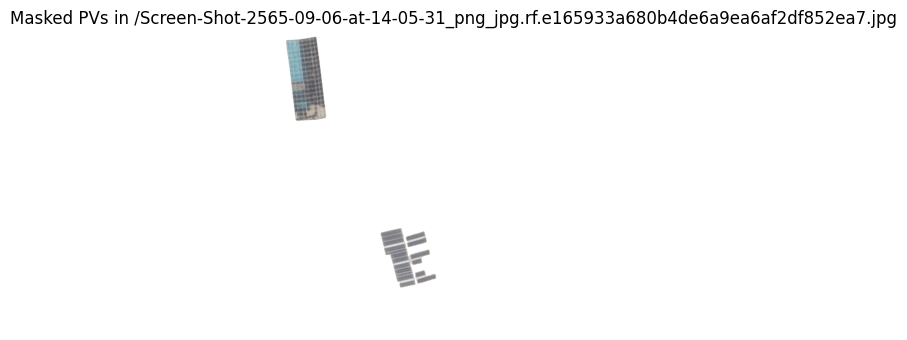

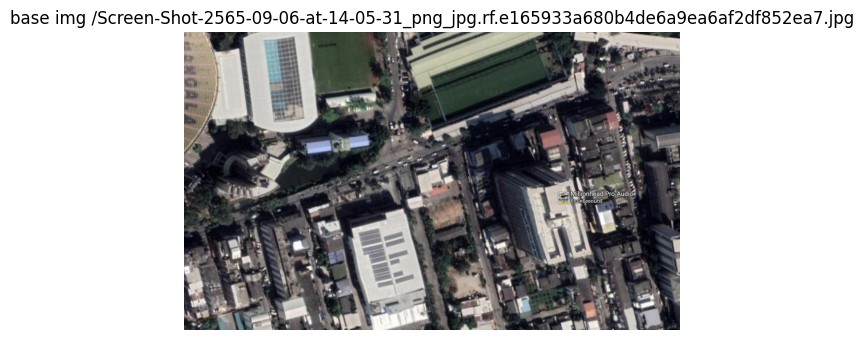

tensor(0.0281, device='cuda:0')

In [13]:
sum_pv_segments("rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Screen-Shot-2565-09-06-at-14-05-31_png_jpg.rf.e165933a680b4de6a9ea6af2df852ea7.jpg", "proste_funk", disp_img=True)

these were not nicely separated at first

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1102.3ms
Speed: 3.7ms preprocess, 1102.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)


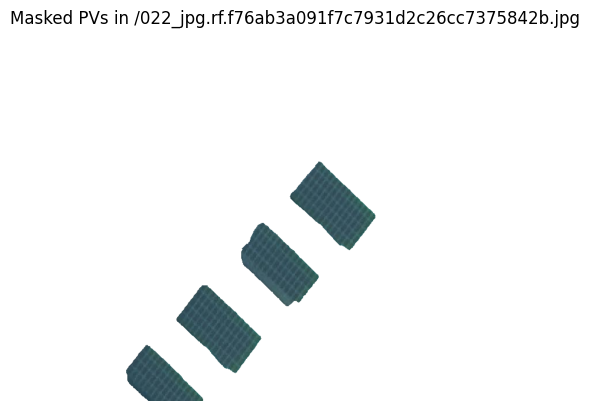

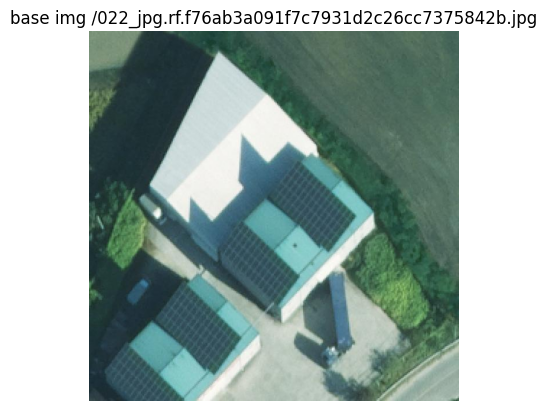

tensor(0.0966, device='cuda:0')

In [14]:
sum_pv_segments(data_p, "proste_funk", disp_img=True)

on the contrary to these neat ones


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1099.9ms
Speed: 3.6ms preprocess, 1099.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


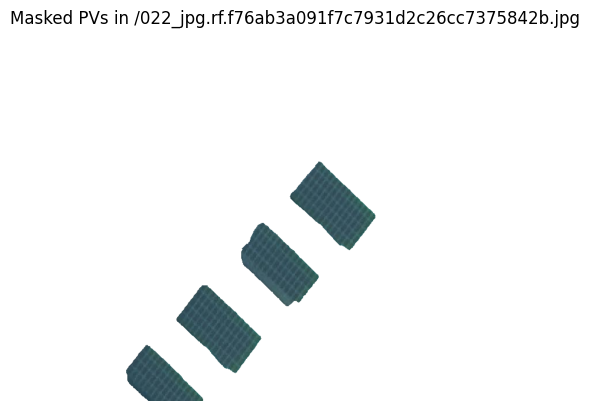

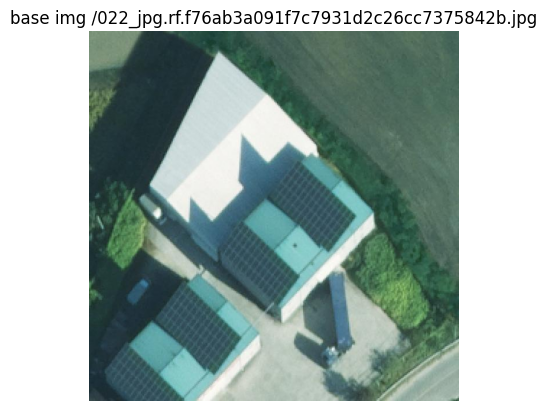


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1110.2ms
Speed: 3.9ms preprocess, 1110.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)


tensor(0.1931, device='cuda:0')

In [15]:
sum_pv_segments([data_p,data_p], "proste_funk_podwojnie", disp_img=True)

## pilot


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-291-_png.rf.c105b47207c9dc4203900bab38f73c89.jpg: 1024x1024 1 0, 1 1, 1 2, 1075.8ms
Speed: 4.5ms preprocess, 1075.8ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)


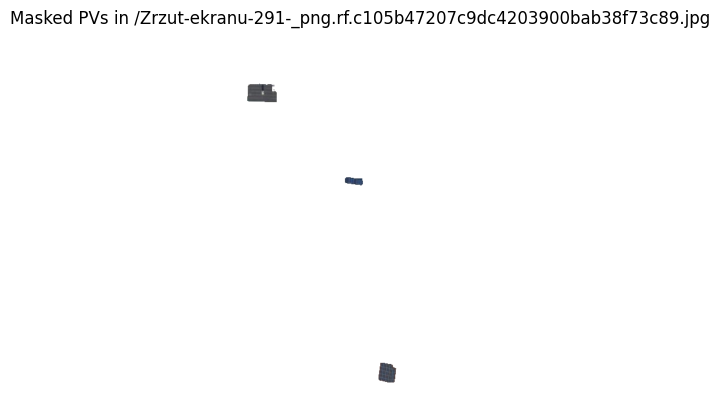

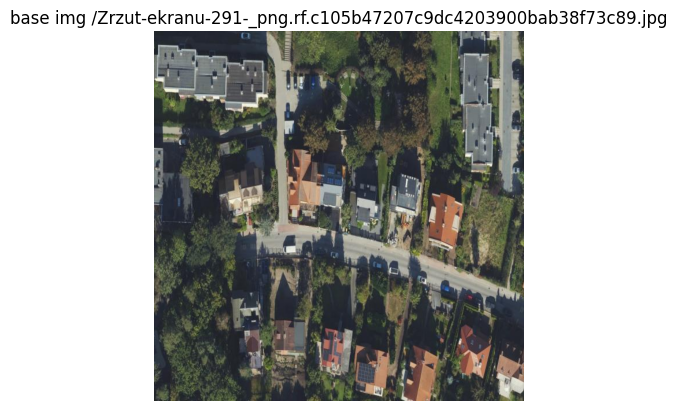


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-293-_png.rf.6501de77787921a2b0c0a3fac3ff7882.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1158.8ms
Speed: 4.1ms preprocess, 1158.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-294-_png.rf.ec19d20eeaa7c3a1ea9c829158bbebdc.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1070.8ms
Speed: 3.8ms preprocess, 1070.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-296-_png.rf.6cb900278610471a7c56cf2c1dda3c82.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1105.0ms
Speed: 4.1ms preprocess, 1105.0ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modell

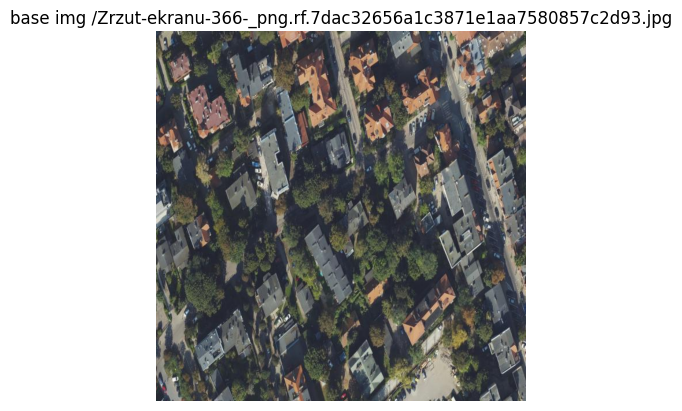


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-370-_png.rf.19faad52d9fa084df8ee42ecb144a1af.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1195.5ms
Speed: 5.7ms preprocess, 1195.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-371-_png.rf.a5aeb36b3d731bccbf03bb6872d3e06e.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1116.9ms
Speed: 4.4ms preprocess, 1116.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-373-_png.rf.9943593aabbafa50c488d826401c6879.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1118.2ms
Speed: 4.0ms preprocess, 1118.2ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/mar

tensor(0.2990, device='cuda:0')

In [16]:
sum_pv_segments(pilot, "pilot_segment", disp_img=True, display_coef=33)

## synthetic

### train


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-141951_png.rf.71f8969cded34224572d3d3b4b7bbf07.jpg: 1024x1024 1 0, 1052.7ms
Speed: 5.7ms preprocess, 1052.7ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)


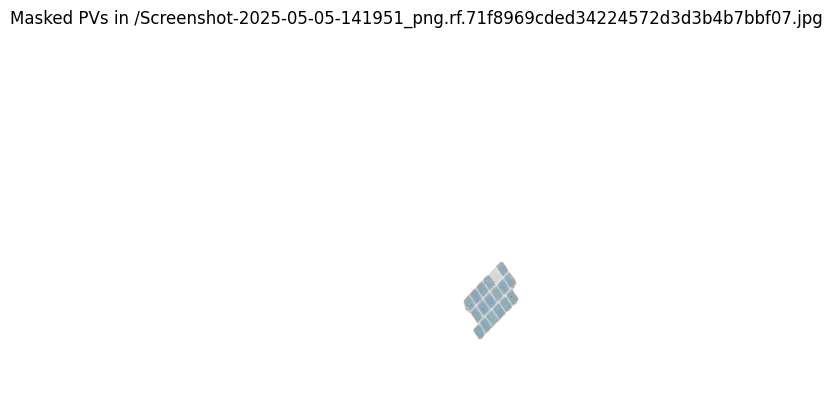

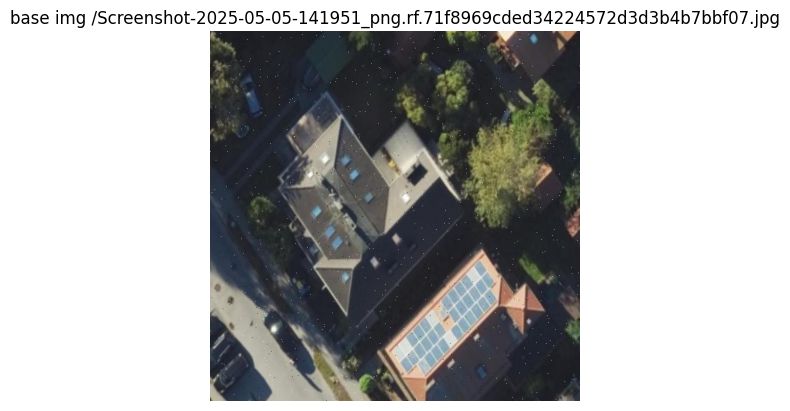


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-141951_png.rf.e8fc3301803b30373229d81dfd39a192.jpg: 1024x1024 1 0, 1 1, 1030.1ms
Speed: 4.5ms preprocess, 1030.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-141951_png.rf.fce413ee410f6a8aa17e7b99dccc1725.jpg: 1024x1024 1 0, 1030.5ms
Speed: 3.6ms preprocess, 1030.5ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-142049_png.rf.3ba62fc2067b311bf450a681e11330af.jpg: 1024x1024 1 0, 1 1, 1040.6ms
Speed: 3.5ms preprocess, 1040.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/tr

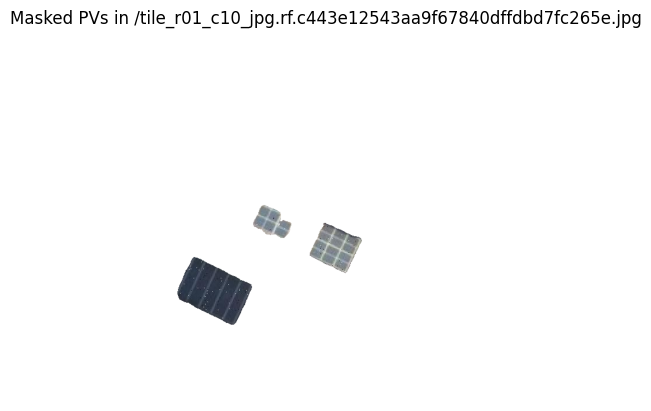

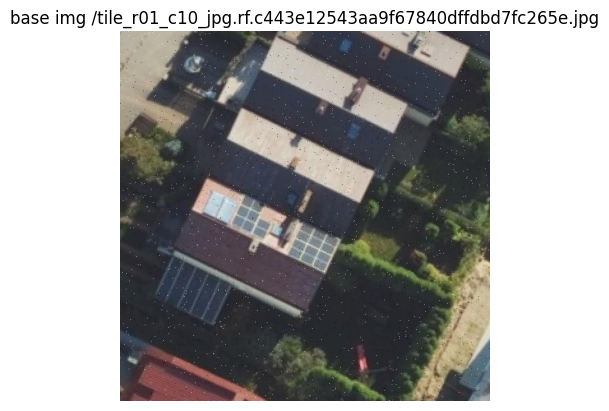


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile_r01_c10_jpg.rf.d0bc46921471d10337c38cf533e39d8c.jpg: 1024x1024 1 0, 990.4ms
Speed: 4.9ms preprocess, 990.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile_r02_c01_jpg.rf.28ff9efcb558b92c9bfa835c75c62c4b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1030.2ms
Speed: 3.8ms preprocess, 1030.2ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile_r02_c01_jpg.rf.a162a1877cd5a9c7802054c5044b06a9.jpg: 1024x1024 1 0, 1 1, 1 2, 1031.5ms
Speed: 3.8ms preprocess, 1031.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile

tensor(3.2677, device='cuda:0')

In [36]:
sum_pv_segments(synth_train, disp_img=True)

### valid


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142243_png.rf.0c1fc1b110982ed45002e385f2ed0cdf.jpg: 1024x1024 1 0, 1 1, 996.5ms
Speed: 5.8ms preprocess, 996.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)


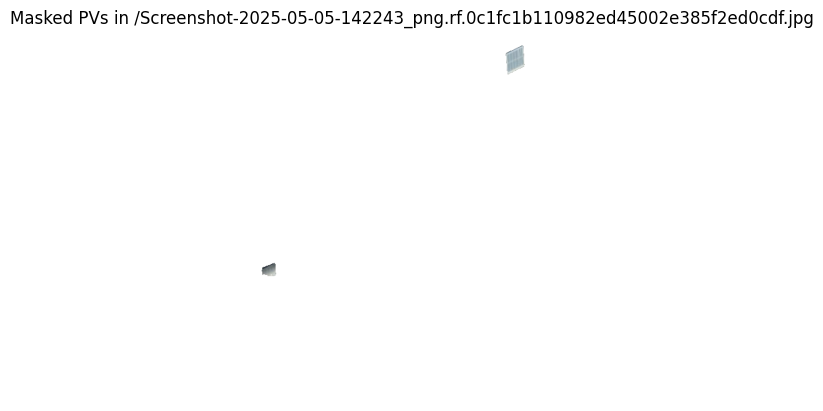

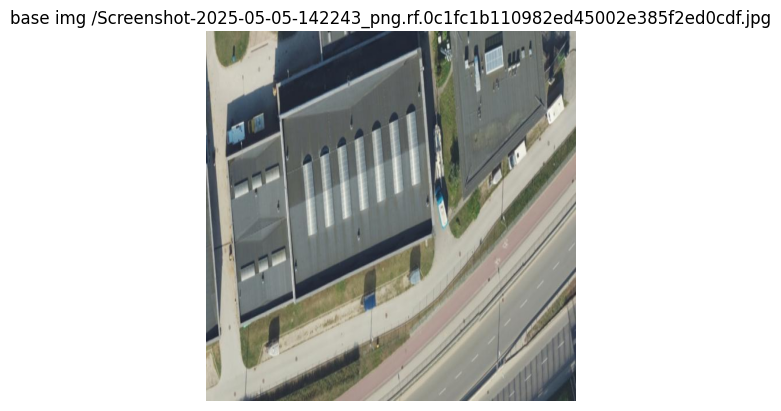


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142342_png.rf.d7373a2eee092999859ee3a20a9e7b13.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1152.6ms
Speed: 6.1ms preprocess, 1152.6ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142412_png.rf.7346005e071261338a10472ee5ae78b1.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1314.2ms
Speed: 5.7ms preprocess, 1314.2ms inference, 2.6ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142633_png.rf.ab6b4d1c58ab4c00e3ddbed5118af28b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1018.1ms
Speed: 6.0ms preprocess, 1018.1ms inference, 1.3ms postprocess 

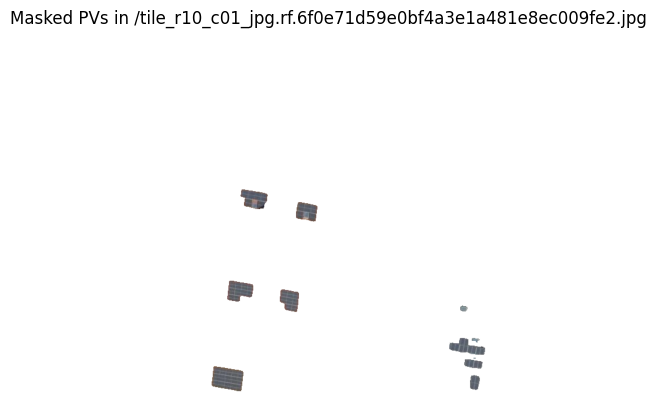

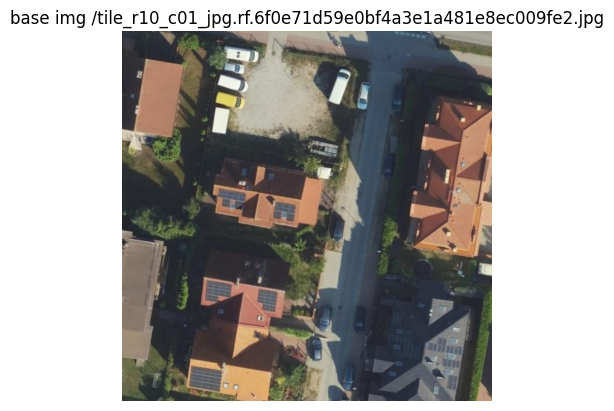


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/tile_r11_c11_jpg.rf.2911fea8c34ab33e7416cb2e7b168c9b.jpg: 1024x1024 1 0, 1 1, 1 2, 1045.4ms
Speed: 5.5ms preprocess, 1045.4ms inference, 3.6ms postprocess per image at shape (1, 3, 1024, 1024)


tensor(0.3497, device='cuda:0')

In [37]:
sum_pv_segments(synth_valid, disp_img=True, display_coef=10)

### test


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143003_png.rf.fdf19d2ceff2192c26f9132617f7138b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1072.4ms
Speed: 15.0ms preprocess, 1072.4ms inference, 3.6ms postprocess per image at shape (1, 3, 1024, 1024)


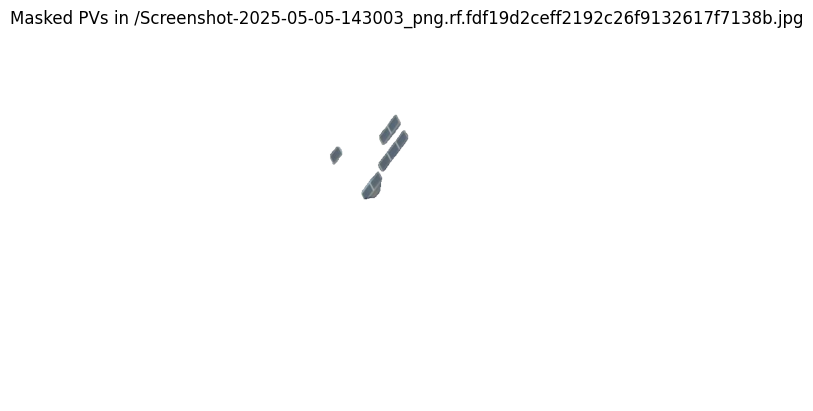

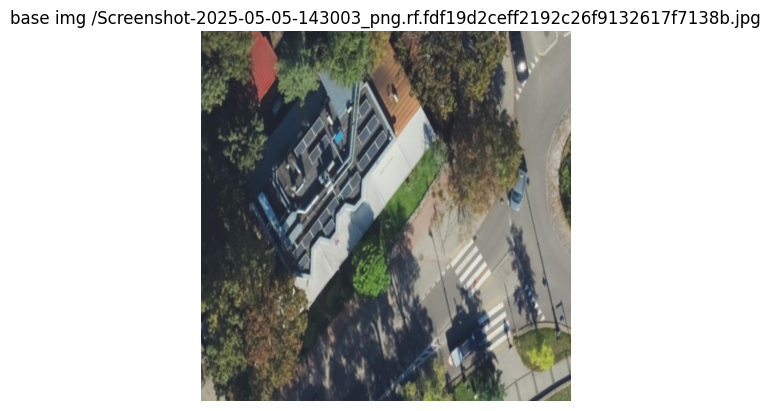


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143259_png.rf.5e77841caaec3af9f76d66e402dada53.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 980.0ms
Speed: 7.6ms preprocess, 980.0ms inference, 3.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143340_png.rf.a3a5eb36c1ae28cb99b95aa17e3d2dd7.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1035.9ms
Speed: 6.0ms preprocess, 1035.9ms inference, 2.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143446_png.rf.315e9c958f42a449d1be8af194c0c849.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1013.0ms
Speed: 5.2ms preprocess, 1013.0ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modell

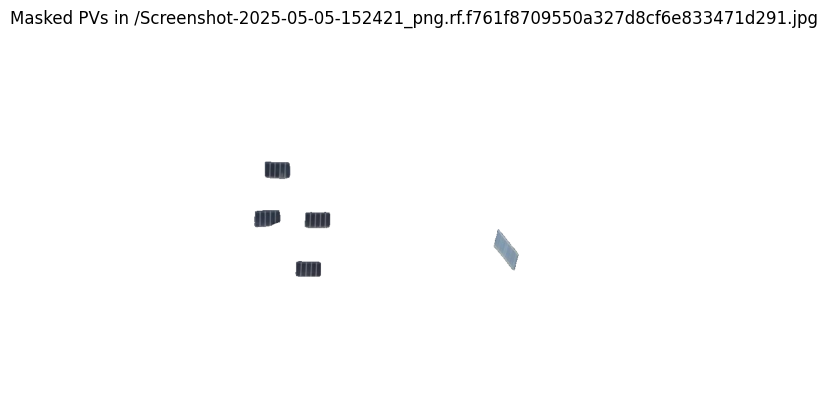

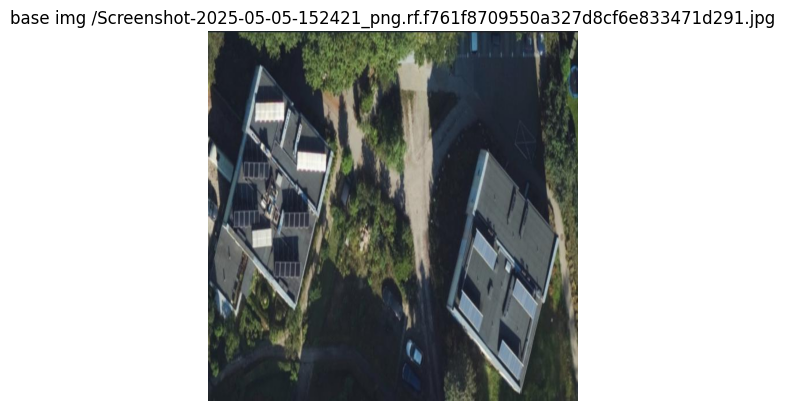


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-152659_png.rf.8f9866c533fda29648957ce56e047208.jpg: 1024x1024 1 0, 1 1, 978.2ms
Speed: 5.9ms preprocess, 978.2ms inference, 3.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-152708_png.rf.f41dbefc9cab846445803af9b77bf4f1.jpg: 1024x1024 1 0, 1 1, 1 2, 1047.5ms
Speed: 5.3ms preprocess, 1047.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-165307_png.rf.87be249f211bca30603740bc852ccd09.jpg: 1024x1024 1 0, 1 1, 1031.1ms
Speed: 5.0ms preprocess, 1031.1ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-o

tensor(0.3867, device='cuda:0')

In [38]:
sum_pv_segments(synth_test, disp_img=True, display_coef=10)

## Rzeszów

### valid


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/006_jpg.rf.edb579f7fc522ebd95b41fb2224d97d9.jpg: 1024x1024 1 0, 1 1, 1035.1ms
Speed: 3.6ms preprocess, 1035.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)


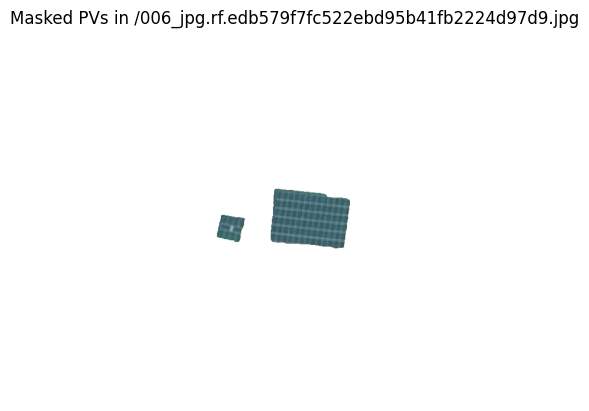

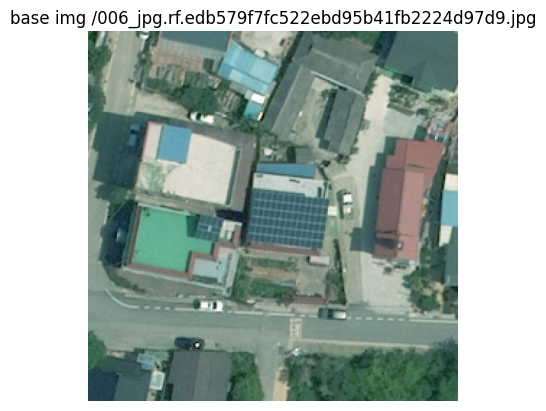


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/024_jpg.rf.2071584ae535b47199dc091fd2420eb7.jpg: 1024x1024 1 0, 1 1, 987.1ms
Speed: 4.3ms preprocess, 987.1ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/036_jpg.rf.6be19359a40387d36e881c8e4589c4ef.jpg: 1024x1024 1 0, 1 1, 1 2, 1054.4ms
Speed: 3.8ms preprocess, 1054.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/037_jpg.rf.da5d0dcc434c04835bb7701b18a7405d.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1071.3ms
Speed: 4.1ms preprocess, 1071.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/039_jpg.rf.1ea41523c4113f9b7b085ba96ebca1c9.jp

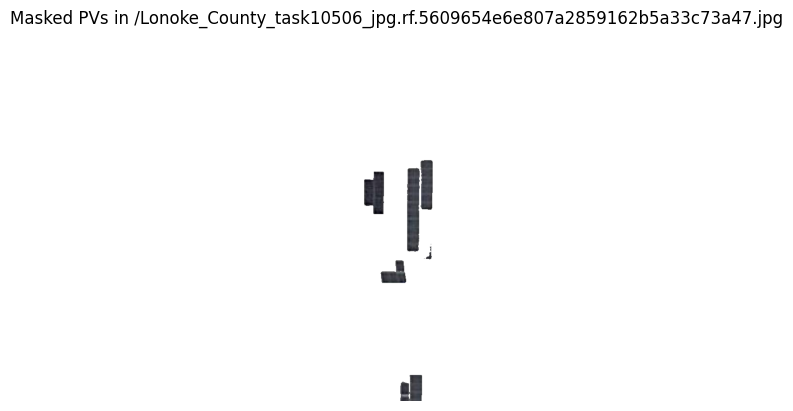

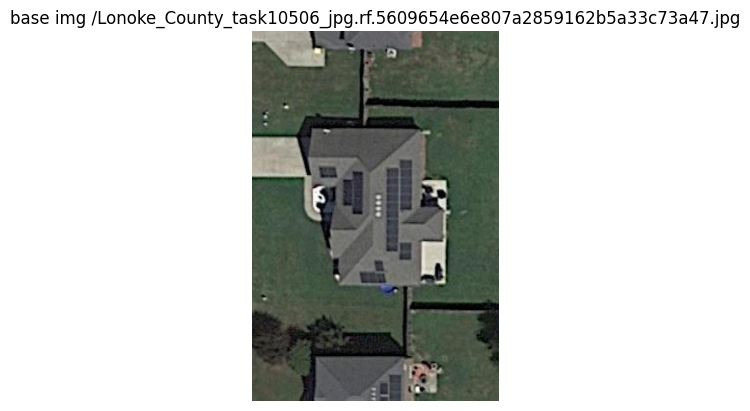


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Lonoke_County_task10811_jpg.rf.ad15471c497bcfd012133246f80853e5.jpg: 1024x1024 1 0, 1 1, 901.3ms
Speed: 3.7ms preprocess, 901.3ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Lonoke_County_task11768_jpg.rf.11f1ea8fb8e18e03efa140ad20668caa.jpg: 1024x1024 1 0, 931.7ms
Speed: 3.6ms preprocess, 931.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Lonoke_County_task1258_jpg.rf.b137128531187339a879b284ebae9e4f.jpg: 1024x1024 1 0, 921.4ms
Speed: 4.0ms preprocess, 921.4ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Lonoke_County_ta

KeyboardInterrupt: 

In [53]:
sum_pv_segments(rzeszow_valid, disp_img=True, display_coef=333)

### test


image 1/441 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/002_jpg.rf.ebb4fe3f88e1352ef612c9da79184d51.jpg: 640x640 4 solar-panels, 22.8ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/002_jpg.rf.ebb4fe3f88e1352ef612c9da79184d51.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1017.2ms
Speed: 5.4ms preprocess, 1017.2ms inference, 8.1ms postprocess per image at shape (1, 3, 1024, 1024)


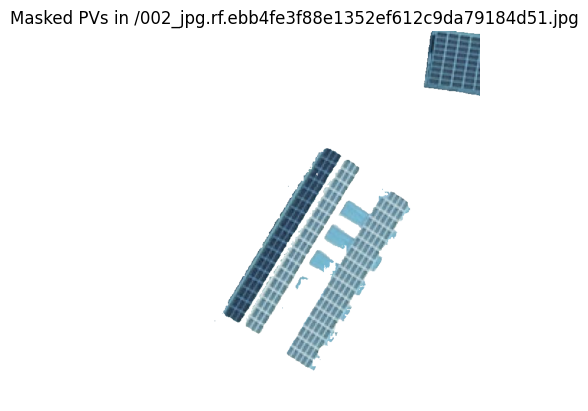

0 0.13206543028354645


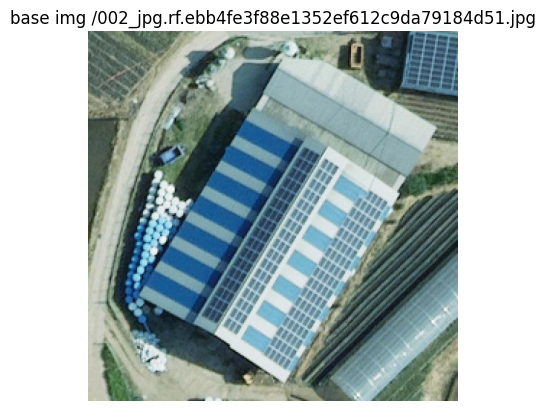

image 2/441 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/006_jpg.rf.96d8625007780d1583d28aafe467a98b.jpg: 640x640 2 solar-panels, 18.9ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/006_jpg.rf.96d8625007780d1583d28aafe467a98b.jpg: 1024x1024 1 0, 1 1, 914.0ms
Speed: 4.6ms preprocess, 914.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)
1 0.16473115980625153
image 3/441 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/010_jpg.rf.0f7f56bba5e16ee4258b6f6c8b502c89.jpg: 640x640 1 solar-panel, 21.7ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/010_jpg.rf.0f7f56bba5e16ee4258b6f6c8b502c89.jpg: 1024x1024 1 0, 900.0ms
Speed: 4.5ms preprocess, 900.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)
2 0.18662568926811218
image 4/441 /home/marekd6/ZPB/modelling/modell

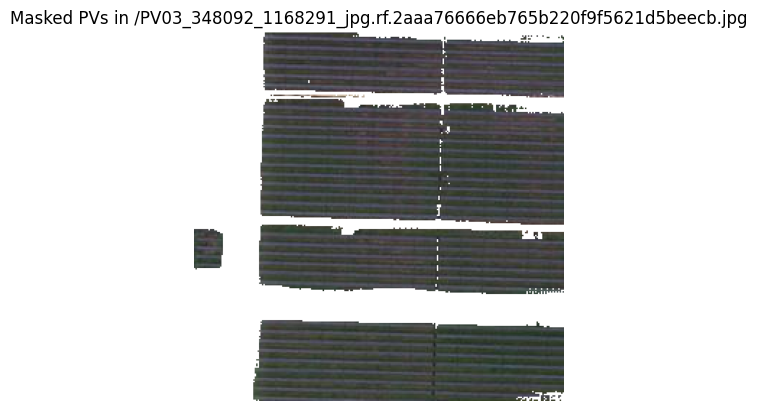

333 33.150264739990234


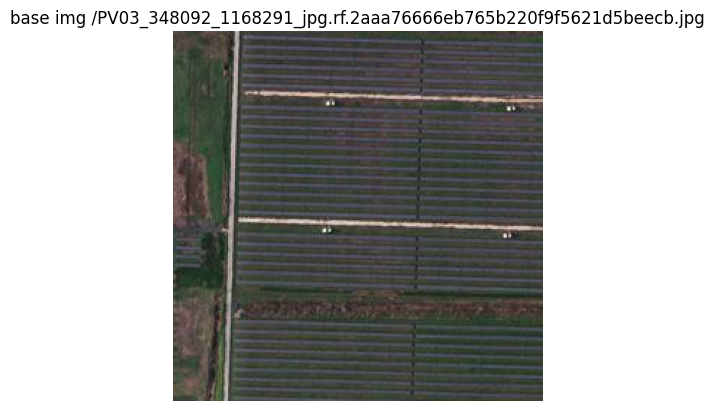

image 335/441 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/PV03_348148_1168289_jpg.rf.8b55230fc999046b8ff87b5a40138c67.jpg: 640x640 2 solar-panels, 19.6ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/PV03_348148_1168289_jpg.rf.8b55230fc999046b8ff87b5a40138c67.jpg: 1024x1024 1 0, 1 1, 930.4ms
Speed: 4.0ms preprocess, 930.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)
334 33.247066497802734
image 336/441 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/PV03_348517_1168644_jpg.rf.72c78461e4b2e696eab93df72bd14e7d.jpg: 640x640 1 solar-panel, 20.6ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/PV03_348517_1168644_jpg.rf.72c78461e4b2e696eab93df72bd14e7d.jpg: 1024x1024 1 0, 929.7ms
Speed: 4.4ms preprocess, 929.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)

tensor(47.0765, device='cuda:0')

In [10]:
sum_pv_segments(rzeszow_test, disp_img=True, display_coef=333, print_info=True)